<a href="https://colab.research.google.com/github/deshwalmahesh/blog-colab-links/blob/main/LanceDB_Matryoshka_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers einops datasets sentence-transformers lancedb "tantivy>=0.20.1" -qq
# NOTE: If there is an import error, restart and run the notebook again

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import lancedb
import re
import pandas as pd
import random

from datasets import load_dataset

import torch
import gc

from tqdm.auto import tqdm

import lance
from lancedb.embeddings import with_embeddings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
import numpy as np


import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

pd.set_option('max_colwidth', 300)

# Matryoshka 🪆 Embedding from [nomic-ai](https://huggingface.co/nomic-ai/)


In [ ]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)


def get_base_embeddings(sentences:list):
    with torch.no_grad():
      embeddings = model.encode(sentences, convert_to_tensor=True).cpu()
      embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
    return embeddings.numpy()

def truncate_normalize_embeds(embeddings, matryoshka_dim = 768):
    embeddings = embeddings[:, :matryoshka_dim]
    return normalize(embeddings, norm='l2', copy=False)

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [ ]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas().dropna(subset = "text").head(10000)
queries["text"] = queries["text"].apply(lambda x: "search_query: "+x) # Queries are encoded in a specific format with prefix


docs = load_dataset('BeIR/scidocs', 'corpus')["corpus"].to_pandas().dropna(subset = "text").head(10000) # just random samples for faster embed demo
docs["text"] = docs["text"].apply(lambda x: "search_document: "+x) # Documents are encoded in a specific format with prefix

docs.sample(3)

,_id,title,text
400,01cac0a7c2a3240cb77a1e090694a104785f78f5,Workflow Automation: Overview and Research Issues,"search_document: Workflow management systems, ..."
5286,3e28d80281d769a32ff5eb7f9a713b3ae01f6475,Analysis on robust H∞ performance and stabilit...,"search_document: In this paper, the problem of..."
9921,3505447904364877605aabaa450c09568c8db1ec,Smart irrigation using low-cost moisture senso...,search_document: Deficiency in fresh water res...


In [ ]:
BATCH_SIZE = 12
BATCHES = [docs["text"].values[i:i + BATCH_SIZE] for i in range(0, docs.shape[0], BATCH_SIZE)]


embeds = []
for batch in tqdm(BATCHES):
  embeds.extend(get_base_embeddings(batch))

(12,)


  0%|          | 0/834 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA

docs["base_embeds"] = embeds # NOTE: These are Un-Normalized full Vectors

base_embed = np.vstack(docs["base_embeds"])

docs["myt_norm_256"] = truncate_normalize_embeds(base_embed, matryoshka_dim = 256).tolist() # Save the Normalized 256 dim
docs["myt_norm_64"] = truncate_normalize_embeds(base_embed, matryoshka_dim = 64).tolist()

# Letssss do some PCAaaaaaaaaaaaa
pca_256 = PCA(n_components = 256)
docs["pca_norm_256"] = normalize(pca_256.fit_transform(base_embed), norm='l2', copy=False).tolist()

pca_64 = PCA(n_components = 64)
docs["pca_norm_64"] = normalize(pca_64.fit_transform(base_embed), norm='l2', copy=False).tolist()

# Create Database and Tables using [`LanceDB`](https://github.com/lancedb/lancedb)

Create **Multiple Tables** based on Embedding Size for Experiment purpose using a `list` of `dicts`

In [ ]:
db = lancedb.connect("./db")

tables = {}
for name in ["base_embeds","myt_norm_256", "myt_norm_64","pca_norm_256", "pca_norm_64"]:
  data = docs.apply(lambda row: {"text":row["text"], "vector":row[name]}, axis = 1).tolist()
  tables[name] = db.create_table(name, data,  mode="overwrite", exist_ok=True)

In [ ]:
QUERY = "search_query: Show me something exciting that is used in spy films and save someone from enemies by saving the secret"

tables["base_embeds"].search(model.encode(QUERY), query_type = "vector").limit(5).to_pandas()

,text,vector,_distance
0,search_document: In this paper we present a new approach for data exfiltration by leaking data from monitor's LED to Smartphone's camera. The new approach may be used by attackers to leak valuable information from the organization as part of an Advanced Persistent Threat (APT). The proof of conc...,"[1.1999751, 1.2014464, -5.5781975, -0.49566674, 2.6565, -0.5665008, -0.4351126, 0.07253115, 0.71052635, 0.44164816, -0.049716987, 0.46261775, 2.2317884, 0.38135594, -0.80140567, -0.40065837, 0.805475, -2.4617865, -0.5998149, -0.19737455, -0.3609587, -1.4525658, -0.96137804, 0.30362704, 0.4006969...",450.879425
1,"search_document: A decent movie summary is helpful for movie producer to promote the movie as well as audience to capture the theme of the movie before watching the whole movie. Most exiting automatic movie summarization approaches heavily rely on video content only, which may not deliver ideal ...","[-0.40919286, 0.019189226, -4.6530733, -0.97683036, -0.7027222, -0.60463816, 1.4009506, 0.18127057, -0.76519877, 0.061476577, -0.7252327, 1.4568461, 2.3243065, 1.7165322, -0.4171177, -2.4997067, -0.25410056, -1.9974631, 0.36762977, 1.1870182, -0.7339198, -0.3773254, 0.9500127, 0.39543328, 0.2861...",467.382782
2,"search_document: In this paper, we describe the experiments conducted by the Information Retrieval Group at the Universidad Autónoma de Madrid (Spain) in order to better recommend movies for the 2010 CAMRa Challenge edition. Experiments were carried out on the dataset corresponding to social Fil...","[-0.27934843, 0.31406474, -5.8621163, 0.030889366, 1.5752124, -0.105805375, 1.4819874, 0.17532429, -0.86874396, 1.4395707, 0.121050864, 0.3761909, 2.0467606, 0.8501791, -1.9484274, -0.9690883, -0.30451053, -2.0418026, -1.280879, 1.8122994, -0.15640344, -1.1496084, -0.8388629, 0.40143475, 1.14699...",473.234894
3,"search_document: Although computer security technologies are the first line of defence to secure users, their success is dependent on individuals’ behaviour. It is therefore necessary to persuade users to practice good computer security. Our interview analysis of users’ conceptualization of secu...","[-0.23871233, 2.4287333, -4.9310675, -0.6761004, 2.9630284, 1.2615871, 1.3902686, -0.5906545, 0.6179788, -0.6760017, -0.44070318, -0.3764673, 0.8214854, 0.60769063, 0.28259355, 0.47402185, 0.6041744, -1.6584129, -0.070289195, 0.33987838, -1.3827244, -2.242356, -0.66997164, -0.65401244, 0.9345912...",478.295471
4,"search_document: Moments before the launch of every space vehicle, engineering discipline specialists must make a critical go/no-go decision. The cost of a false positive, allowing a launch in spite of a fault, or a false negative, stopping a potentially successful launch, can be measured in the...","[0.659697, 1.110027, -6.257911, -1.2516385, 0.73001015, -0.117091104, -0.05451157, -0.8024632, -0.043042094, 0.703525, 0.2554595, 1.2294834, 2.7906394, 1.2093097, -0.32647994, -0.49881318, 0.39474326, -1.6855619, -0.21368046, -0.110577404, 0.11571981, -1.9905363, -2.2531579, 0.60508704, 1.095078...",485.875336


In [ ]:
tables["myt_norm_64"].search(model.encode(QUERY)[:64], query_type = "vector").limit(5).to_pandas()

,text,vector,_distance
0,"search_document: A decent movie summary is helpful for movie producer to promote the movie as well as audience to capture the theme of the movie before watching the whole movie. Most exiting automatic movie summarization approaches heavily rely on video content only, which may not deliver ideal ...","[-0.03884234, 0.0018215234, -0.44168964, -0.09272492, -0.0667054, -0.05739484, 0.13298422, 0.017206978, -0.07263594, 0.0058356193, -0.068842195, 0.13829006, 0.2206331, 0.16294058, -0.039594598, -0.23728286, -0.024120312, -0.18960774, 0.03489699, 0.11267684, -0.0696668, -0.03581734, 0.09017927, 0...",52.697174
1,"search_document: We propose a unified model combining the strength of extractive and abstractive summarization. On the one hand, a simple extractive model can obtain sentence-level attention with high ROUGE scores but less readable. On the other hand, a more complicated abstractive model can obt...","[0.056853846, 0.08515425, -0.48451617, -0.119678386, 0.113408566, -0.06608946, 0.14100066, 0.06199508, 0.014735012, 0.08647985, -0.00084406213, -0.009494759, 0.26837277, 0.120546654, 0.05241325, -0.09247665, -0.09642706, -0.17516531, -0.10793687, 0.010141744, -0.11852836, -0.05710325, 0.10410936...",52.761936
2,"search_document: Instant messaging services are quickly becoming the most dominant form of communication among consumers around the world. Apple iMessage, for example, handles over 2 billion messages each day, while WhatsApp claims 16 billion messages from 400 million international users. To pro...","[-0.044686448, 0.13168876, -0.47726673, 0.018797148, 0.23843418, -0.05904826, 0.06778874, -0.016942175, 0.11182148, 0.022729438, -0.11787718, 0.0194644, 0.09780959, 0.04707099, -0.05694962, -0.02613156, 0.06993579, -0.15989344, -0.027019497, 0.104620226, -0.109325014, -0.10427625, -0.15863848, -...",52.929592
3,search_document: In this paper we present a new approach for data exfiltration by leaking data from monitor's LED to Smartphone's camera. The new approach may be used by attackers to leak valuable information from the organization as part of an Advanced Persistent Threat (APT). The proof of conc...,"[0.11320167, 0.113340475, -0.52622867, -0.046759557, 0.2506054, -0.053441804, -0.041047078, 0.0068423483, 0.0670287, 0.041663624, -0.004690136, 0.043641824, 0.21053952, 0.035975855, -0.07560195, -0.03779678, 0.07598584, -0.23223679, -0.056584544, -0.01861966, -0.034051646, -0.13703023, -0.090693...",53.118385
4,"search_document: The advent of social media has brought Internet memes, a unique social phenomenon, to the front stage of the Web. Embodied in the form of images with text descriptions, little do we know about the “language of memes”. In this paper, we statistically study the correlations among ...","[-0.035889424, 0.10514636, -0.549165, -0.07775965, 0.14140105, -0.010107959, 0.06318708, -0.027891511, -0.031283077, -0.08113055, -0.0075078667, -0.04529524, 0.16489197, 0.17038731, -0.16272244, -0.10787354, -0.11084433, -0.17774858, -0.055280037, 0.20678179, -0.12594418, -0.041291855, -0.006507...",53.143688


In [ ]:
query_vec_pca_64 = pca_64.transform(np.array(model.encode(QUERY)).reshape(1,-1)).squeeze().tolist()

tables["pca_norm_64"].search(query_vec_pca_64, query_type = "vector").limit(5).to_pandas()

,text,vector,_distance
0,"search_document: Steganography is the science of embedding the secret messages inside other medium files in a way that hides the existence of the secret message at all. Steganography can be applied to text, audio, image, and video file types. In this study, we propose a new steganography approac...","[0.055597596, -0.0079489965, -0.1534254, 0.20033348, 0.08654744, 0.38471454, 0.077165306, -0.31776834, 0.20058924, 0.20828465, 0.1823485, -0.2823669, 0.05959154, 0.07048868, -0.18003446, -0.088464156, 0.13378596, 0.1281244, -0.16603579, -0.1368443, -0.06927044, -0.0876522, 0.19271585, 0.15623349...",62.776100
1,"search_document: Steganography is the art of hiding information in ways that prevent the detection of hidden messages. It includes a vast array of secret communications methods that conceal the message's very existence. These methods include invisible inks, microdots, character arrangement, digi...","[0.28567603, 0.0287257, -0.2108729, 0.18090379, 0.030682908, 0.32026786, 0.16182643, -0.20618111, 0.20389782, 0.19636694, 0.3363665, -0.35369608, 0.060997996, 0.12289439, -0.04002951, -0.07928791, 0.05693286, 0.11397273, -0.15951547, -0.11975686, -0.025553247, -0.14363201, 0.088561796, 0.0570295...",63.233067
2,search_document: Steganography is the art and science of invisible communication. It is a technique which keeps the existence of the message secret. This paper proposed a technique to implement steganogaraphy and cryptography together to hide the data into an image. This technique describes as: ...,"[0.07927779, 0.14532983, -0.2948822, 0.20902091, 0.044777382, 0.26745832, 0.123559035, -0.27851468, 0.19378431, 0.14955911, 0.32586652, -0.25417477, 0.03165007, 0.10148165, -0.120023966, -0.0793266, 0.063641235, 0.08702085, -0.025876204, -0.18259698, -0.14910556, -0.10276479, 0.15549777, 0.09662...",63.237297
3,search_document: Rubén Prieto-Díaz Commonwealth Information Security Center James Madison University prietodiaz@cisat.jmu.edu,"[0.17396444, 0.15562366, -0.115372606, 0.11007108, 0.07463497, 0.100745656, 0.021472532, -0.025261184, 0.053155415, 0.037618075, 0.2709511, 0.28362074, -0.06928512, 0.09865667, -0.04354394, -0.27042904, 0.16957359, -0.2941215, 0.079523705, -0.13022543, -0.29274535, 0.09803123, 0.07514186, -0.035...",63.457172
4,"search_document: Moments before the launch of every space vehicle, engineering discipline specialists must make a critical go/no-go decision. The cost of a false positive, allowing a launch in spite of a fault, or a false negative, stopping a potentially successful launch, can be measured in the...","[0.003466668, 0.18718743, -0.044916455, -0.10192043, 0.17388238, 0.018579064, -0.0527289, -0.100414924, -0.2851663, -0.007015505, -0.16814277, 0.073167525, 0.1426893, -0.18069834, -0.026484597, -0.3191771, 0.031202381, 0.08062107, -0.20106472, 0.05142459, -0.2327922, 0.0319004, 0.21958303, -0.00...",63.479267


In [ ]:
%timeit tables["base_embeds"].search(model.encode("search_query: sky self control")).limit(5).to_pandas()

40.8 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit tables["myt_norm_64"].search(model.encode("search_query: sky self control")[:64]).limit(5).to_pandas()

27.6 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


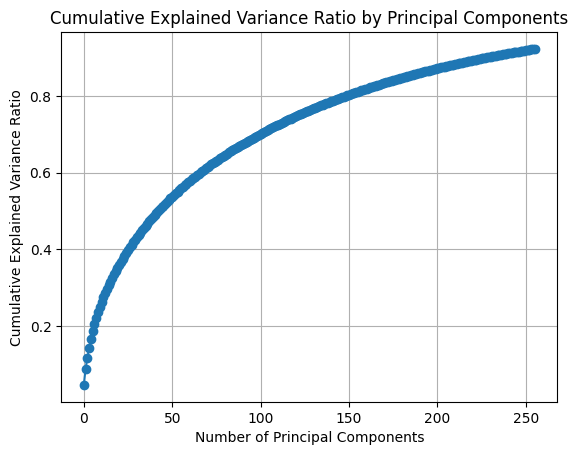

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

explained_variance_ratio = pca_256.explained_variance_ratio_

# Plot explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.grid()
plt.show()